# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020
## Timeseries Analysis

Author: Mark Bauer

# Goal
In this notebook, we perform basic timeseries analysis with NYC's 311 Street Flooding Complaints data from 2010 to 2020. Specifically, I attempt to inspect the following questions:

- How have street flooding complaints changed over time city-wide and by borough?
- Is there any seasonality?
- Are there any overall trends?

# Main Python Libraries:
[pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.

[GeoPandas](https://geopandas.org/index.html) is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

[Matplotlib](https://matplotlib.org/3.1.1/index.html#) is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

[Seaborn](https://seaborn.pydata.org/index.html) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

# Datasets

## 311 Service Requests from 2010 to Present  
Website: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

311's data dictionary can be found in the data folder. 



![311](images/nyc-311-screenshot.png)

## Neighborhood Tabulation Areas (NTA)  
Website: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq

![nta](images/nyc-nta-screenshot.png)

# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing versions of Python modules and packages with **watermark** - the IPython magic extension.  
Documention for installing watermark: https://github.com/rasbt/watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,geopandas,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

numpy     : 1.23.4
pandas    : 1.5.1
geopandas : 0.12.1
matplotlib: 3.6.2
seaborn   : 0.12.1



# Read In Data

In [3]:
# list items in data folder
%ls data/

README.md                               streets-clipped.gpkg
street-flooding-complaints-cleaned.csv  streets.gpkg
street-flooding-complaints.csv          water-main-breaks.csv


In [4]:
# read data as a dataframe
path = 'data/street-flooding-complaints-cleaned.csv'
df = pd.read_csv(path, low_memory=False)

# sanity checks
print(f'shape of data: {df.shape}')
print(f"unique key is unique: {df['unique_key'].is_unique}")

# preview data
df.head()

shape of data: (24817, 27)
unique key is unique: True


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,cross_street_1,cross_street_2,address_type,...,incident_zip,city,x_coordinate_state_plane,y_coordinate_state_plane,latitude,longitude,location,incident_address,street_name,bbl
0,34783066,2016-11-15T09:27:00.000,2016-11-15T10:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,NaN,INTERSECTION,...,10301.0,STATEN ISLAND,958594.0,170855.0,40.635597,-74.092438,"{'latitude': '40.635596930697716', 'longitude'...",NaN,NaN,NaN
1,36178846,2017-05-13T14:41:00.000,2017-11-08T11:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),32 AVE,78 ST,INTERSECTION,...,11370.0,East Elmhurst,1014871.0,215198.0,40.757292,-73.889472,"{'latitude': '40.75729226742685', 'longitude':...",NaN,NaN,NaN
2,31360389,2015-08-21T05:46:00.000,2015-08-26T10:27:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),110 AVE,110 RD,ADDRESS,...,11433.0,JAMAICA,1043288.0,192114.0,40.693788,-73.787102,"{'latitude': '40.69378840426638', 'longitude':...",110-07 164 PLACE,164 PLACE,4.101930e+09
3,32686230,2016-02-15T13:10:00.000,2016-02-16T14:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ALDUS ST,HOE AVE,INTERSECTION,...,10459.0,BRONX,1014578.0,239190.0,40.823145,-73.890421,"{'latitude': '40.82314481234778', 'longitude':...",NaN,NaN,NaN
4,41495135,2019-01-23T11:59:00.000,2019-01-28T13:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),102 ST,DEAD END,ADDRESS,...,11414.0,HOWARD BEACH,1031172.0,179312.0,40.658722,-73.830883,"{'latitude': '40.65872239939313', 'longitude':...",102-20 160 AVENUE,160 AVENUE,4.142340e+09


In [5]:
# column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24817 entries, 0 to 24816
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      24817 non-null  int64  
 1   created_date                    24817 non-null  object 
 2   closed_date                     24816 non-null  object 
 3   agency                          24817 non-null  object 
 4   agency_name                     24817 non-null  object 
 5   complaint_type                  24817 non-null  object 
 6   descriptor                      24817 non-null  object 
 7   cross_street_1                  21821 non-null  object 
 8   cross_street_2                  21816 non-null  object 
 9   address_type                    24817 non-null  object 
 10  status                          24817 non-null  object 
 11  resolution_description          24813 non-null  object 
 12  resolution_action_updated_date  

# Data Wrangling

In [6]:
# convert to datetime
df['created_date'] = pd.to_datetime(df['created_date'])
df['year_dt'] = df['created_date'].dt.year
df['year_month_day'] = pd.to_datetime(df['created_date'].dt.strftime('%Y-%m-%d'))
df['year_month'] = df['created_date'].dt.to_period('M')
df['year_month_week'] = pd.to_datetime(df['created_date'].dt.strftime('%Y-%W') + '0', format='%Y-%W%w')

# extract datetime attribute
df['year'] = df['created_date'].dt.year
df['month'] = df['created_date'].dt.month
df['quarter'] = df['created_date'].dt.quarter
df['week_of_year'] = df['created_date'].dt.isocalendar().week
df['day_name'] = df['created_date'].dt.day_name()
df['day'] = df['created_date'].dt.day 
df['hour'] = df['created_date'].dt.hour
df['time'] = df['created_date'].dt.time
df['am_pm'] = df['created_date'].dt.strftime('%p')

# examine columns
df.head().iloc[:, -12:]

,year_month_day,year_month,year_month_week,year,month,quarter,week_of_year,day_name,day,hour,time,am_pm
0,2016-11-15,2016-11,2016-11-20,2016,11,4,46,Tuesday,15,9,09:27:00,AM
1,2017-05-13,2017-05,2017-05-14,2017,5,2,19,Saturday,13,14,14:41:00,PM
2,2015-08-21,2015-08,2015-08-23,2015,8,3,34,Friday,21,5,05:46:00,AM
3,2016-02-15,2016-02,2016-02-21,2016,2,1,7,Monday,15,13,13:10:00,PM
4,2019-01-23,2019-01,2019-01-27,2019,1,1,4,Wednesday,23,11,11:59:00,AM


In [7]:
# examine columns
df.head().iloc[:, -12:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   year_month_day   5 non-null      datetime64[ns]
 1   year_month       5 non-null      period[M]     
 2   year_month_week  5 non-null      datetime64[ns]
 3   year             5 non-null      int64         
 4   month            5 non-null      int64         
 5   quarter          5 non-null      int64         
 6   week_of_year     5 non-null      UInt32        
 7   day_name         5 non-null      object        
 8   day              5 non-null      int64         
 9   hour             5 non-null      int64         
 10  time             5 non-null      object        
 11  am_pm            5 non-null      object        
dtypes: UInt32(1), datetime64[ns](2), int64(5), object(3), period[M](1)
memory usage: 593.0+ bytes


In [8]:
# transform boro title case
df['borough'] = df['borough'].str.title()

# examine boro values
df['borough'].value_counts()

Queens           9814
Brooklyn         6246
Staten Island    4626
Manhattan        2372
Bronx            1754
Unspecified         5
Name: borough, dtype: int64

In [9]:
# drop Unspecified values
df = df.loc[df.borough != 'Unspecified'].reset_index(drop=True)

df['borough'].value_counts()

Queens           9814
Brooklyn         6246
Staten Island    4626
Manhattan        2372
Bronx            1754
Name: borough, dtype: int64

# Descriptive Statistics

## Counts per Year and Borough

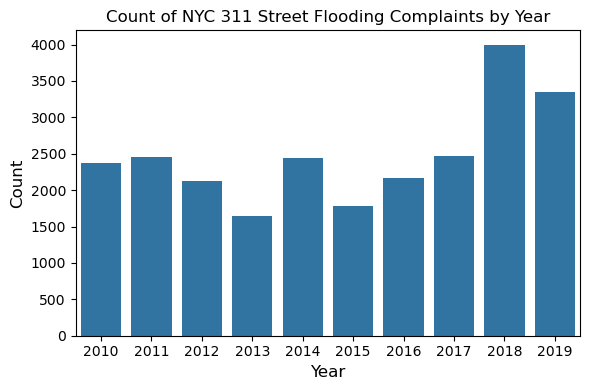

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(x=df['year'], color='#1f77b4')

label = 'Count of NYC 311 Street Flooding Complaints by Year'
plt.title(label, fontsize=12)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()

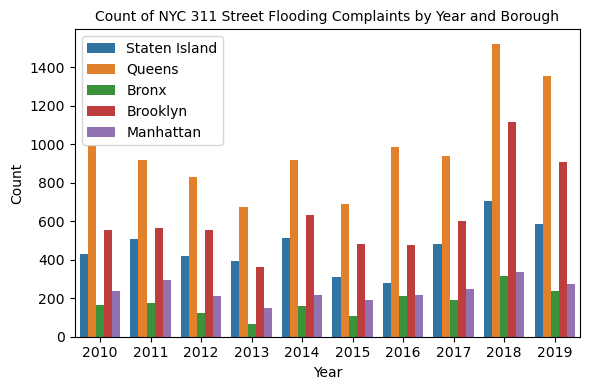

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(x=df['year'], hue=df['borough'])

label = 'Count of NYC 311 Street Flooding Complaints by Year and Borough'
plt.title(label, fontsize=10)

plt.legend()
plt.xlabel('Year')
plt.ylabel('Count')

plt.tight_layout()

In [12]:
# transform to pivot table
pivot_df = pd.pivot_table(
    df,
    values='unique_key',
    index=['year'],
    columns=['borough'],
    aggfunc=pd.Series.nunique
)

# order items in legend consistent to above plot
cols = [
    'Queens', 'Brooklyn',
    'Manhattan',
    'Staten Island', 'Bronx'
]

pivot_df = pivot_df.loc[:, cols]

# examine pivot table
pivot_df.head()

borough,Queens,Brooklyn,Manhattan,Staten Island,Bronx
year,,,,,
2010,988,554,238,429,165
2011,920,566,293,508,174
2012,828,553,209,419,123
2013,673,360,151,391,68
2014,915,632,215,514,161


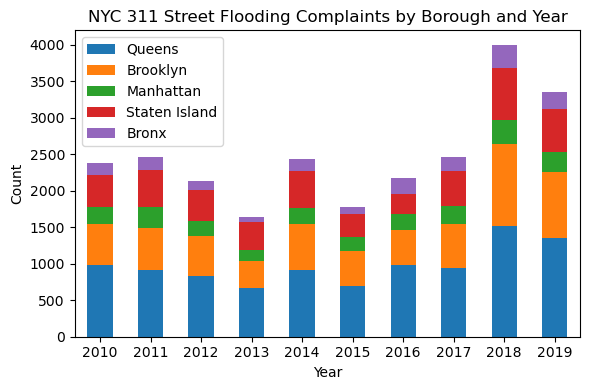

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

pivot_df.plot.bar(stacked=True, ax=ax)

label = 'NYC 311 Street Flooding Complaints by Borough and Year'
plt.title(label)

plt.legend()
plt.xlabel('Year')
plt.ylabel('Count')

plt.xticks(rotation=0)

plt.tight_layout()

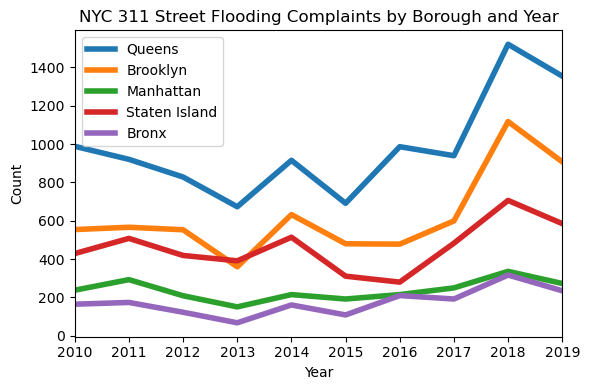

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))

pivot_df.plot.line(ax=ax, linewidth=4)

plt.title('NYC 311 Street Flooding Complaints by Borough and Year', fontsize=12)
plt.legend(loc=2)
plt.xlabel('Year')
plt.ylabel('Count')

plt.xticks(rotation=0)
plt.xlim(2010, 2019)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

plt.tight_layout()

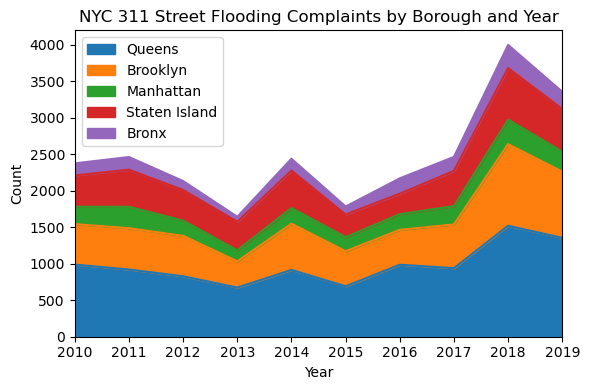

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))

pivot_df.plot.area(ax=ax)

plt.title('NYC 311 Street Flooding Complaints by Borough and Year', fontsize=12)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Count')

plt.xlim(2010, 2019)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

plt.tight_layout()

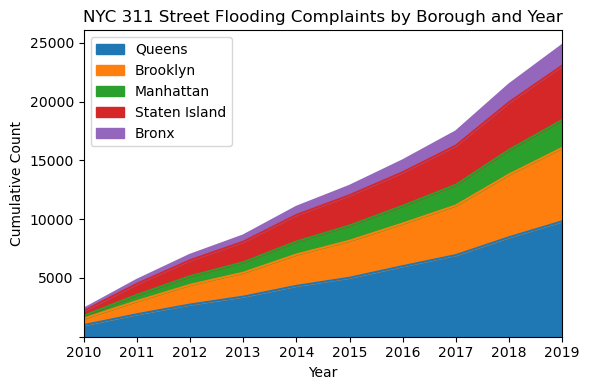

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

pivot_df.cumsum().plot.area(ax=ax)

plt.title('NYC 311 Street Flooding Complaints by Borough and Year')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Cumulative Count')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xticks(rotation=0)
plt.xlim(2010, 2019)
plt.setp(ax.get_yticklabels()[0], visible=False)

plt.tight_layout()

In [17]:
# percent total of pivot table
pivot_perc = (
    pivot_df
    .divide(pivot_df.sum(axis=0), axis=1)
    .mul(100)
    .round(2)
)

pivot_perc.head(10)

borough,Queens,Brooklyn,Manhattan,Staten Island,Bronx
year,,,,,
2010,10.07,8.87,10.03,9.27,9.41
2011,9.37,9.06,12.35,10.98,9.92
2012,8.44,8.85,8.81,9.06,7.01
2013,6.86,5.76,6.37,8.45,3.88
2014,9.32,10.12,9.06,11.11,9.18
2015,7.04,7.68,8.09,6.72,6.21
2016,10.05,7.65,9.06,6.05,11.97
2017,9.57,9.59,10.54,10.44,10.95
2018,15.49,17.88,14.17,15.26,18.07


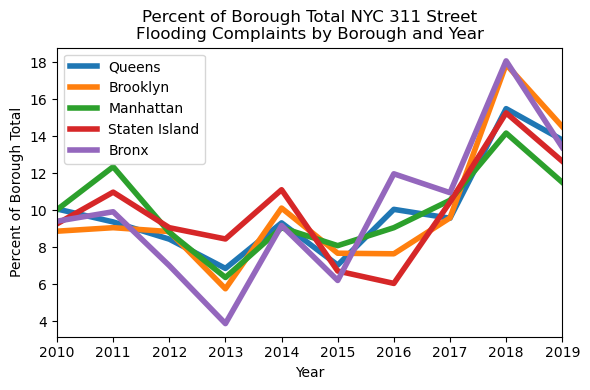

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))

pivot_perc.plot(ax=ax, linewidth=4)

label = 'Percent of Borough Total NYC 311 Street\nFlooding Complaints by Borough and Year'
plt.title(label)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Percent of Borough Total')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xticks(rotation=0)
plt.xlim(2010, 2019)

plt.tight_layout()

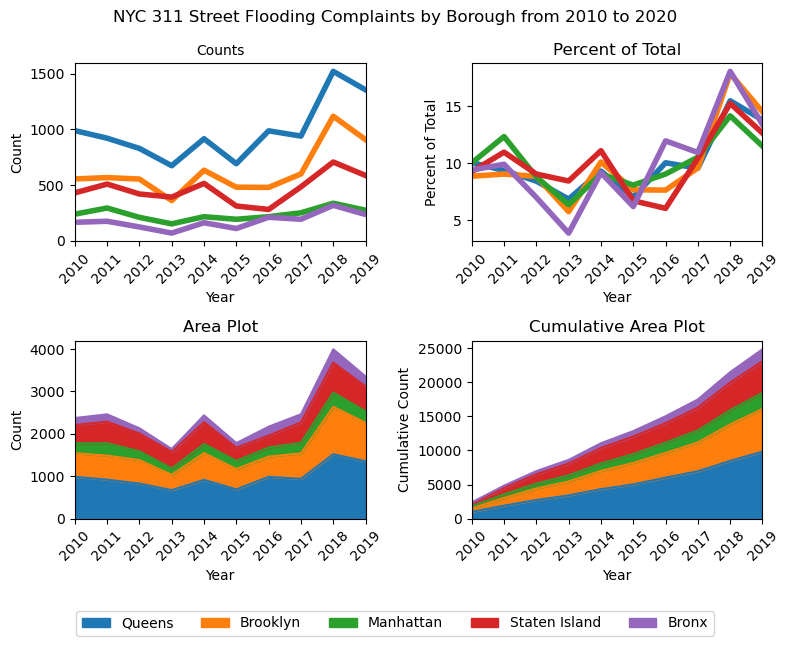

In [19]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(8, 6))

pivot_df.plot.line(linewidth=4, ax=axs[0,0])
axs[0,0].xaxis.set_major_locator(plt.MultipleLocator(1))
axs[0,0].set_ylabel('Count', fontsize=10)
axs[0,0].set_title('Counts', fontsize=10)

pivot_perc.plot(ax=axs[0,1], linewidth=4)
axs[0,1].xaxis.set_major_locator(plt.MultipleLocator(1))
axs[0,1].tick_params(labelrotation=0)
axs[0,1].legend(loc=2, title='borough')
axs[0,1].set_ylabel('Percent of Total')
axs[0,1].set_title('Percent of Total')

pivot_df.plot.area(ax=axs[1,0])
axs[1,0].xaxis.set_major_locator(plt.MultipleLocator(1))
axs[1,0].set_ylabel('Count')
axs[1,0].set_title('Area Plot')
    
pivot_df.cumsum().plot.area(ax=axs[1,1])
axs[1,1].xaxis.set_major_locator(plt.MultipleLocator(1))
axs[1,1].set_ylabel('Cumulative Count')
axs[1,1].set_title('Cumulative Area Plot')

for ax in axs.flat:
    ax.set_xlabel('Year') 
    ax.get_legend().remove()
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xlim(2010, 2019)

h, l = ax.get_legend_handles_labels()
fig.legend(h, l, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=5)

label = 'NYC 311 Street Flooding Complaints by Borough from 2010 to 2020'
fig.suptitle(label, fontsize=12) 

fig.tight_layout()

## Date and Time Information

In [20]:
# resample to daily counts top 10
daily = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('D')
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"unique_key": "count"})
    .assign(date_formatted=lambda x: x.year_month_day.dt.strftime('%Y-%m-%d'))
)

daily.head(10)

,year_month_day,count,date_formatted
0,2017-05-05,239,2017-05-05
1,2014-12-09,216,2014-12-09
2,2014-04-30,185,2014-04-30
3,2013-05-08,158,2013-05-08
4,2018-04-16,149,2018-04-16
5,2016-02-08,146,2016-02-08
6,2016-11-15,140,2016-11-15
7,2018-11-25,131,2018-11-25
8,2010-03-30,121,2010-03-30
9,2014-05-01,118,2014-05-01


In [21]:
# resample to weekly counts top 10
weekly = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('W')
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"unique_key": "count"})
    .assign(date_formatted=lambda x: x.year_month_day.dt.strftime('%Y-%m-%d'))
)

weekly.head(10)

,year_month_day,count,date_formatted
0,2014-05-04,328,2014-05-04
1,2013-05-12,269,2013-05-12
2,2014-12-14,264,2014-12-14
3,2017-05-07,255,2017-05-07
4,2019-07-28,231,2019-07-28
5,2016-02-14,219,2016-02-14
6,2014-02-16,219,2014-02-16
7,2019-12-15,214,2019-12-15
8,2018-03-04,208,2018-03-04
9,2012-05-27,203,2012-05-27


In [22]:
# resample to monthly counts
monthly = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('MS')
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"unique_key": "count"})
    .assign(date_formatted=lambda x: x.year_month_day.dt.strftime('%Y-%b'))
)

monthly.head()

,year_month_day,count,date_formatted
0,2018-11-01,673,2018-Nov
1,2017-05-01,508,2017-May
2,2016-02-01,470,2016-Feb
3,2011-08-01,470,2011-Aug
4,2010-03-01,460,2010-Mar


In [23]:
# resample to yearly counts top 10
yearly = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('YS')
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"unique_key": "count"})
    .assign(date_formatted=lambda x: x.year_month_day.dt.strftime('%Y'))
)

yearly

,year_month_day,count,date_formatted
0,2018-01-01,3996,2018
1,2019-01-01,3354,2019
2,2017-01-01,2463,2017
3,2011-01-01,2461,2011
4,2014-01-01,2437,2014
5,2010-01-01,2374,2010
6,2016-01-01,2169,2016
7,2012-01-01,2132,2012
8,2015-01-01,1783,2015
9,2013-01-01,1643,2013


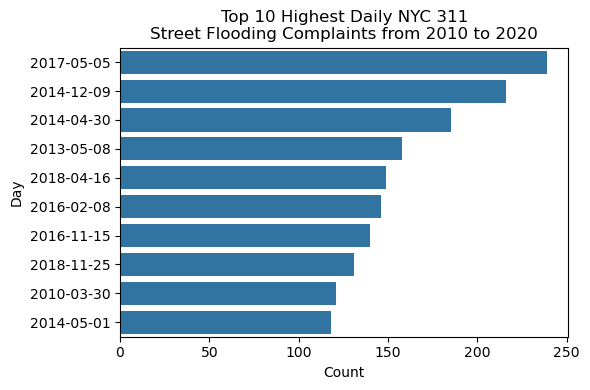

In [24]:
plt.figure(figsize=(6, 4))

sns.barplot(
    data=daily,
    y='date_formatted',
    x='count',
    color='#1f77b4'
)

label = 'Top 10 Highest Daily NYC 311\nStreet Flooding Complaints from 2010 to 2020'
plt.title(label)
plt.xlabel('Count')
plt.ylabel('Day')

plt.tight_layout()

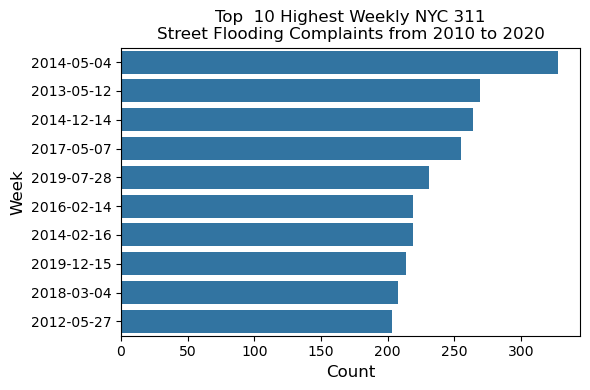

In [25]:
plt.figure(figsize=(6, 4))

sns.barplot(
    data=weekly,
    y='date_formatted',
    x='count',
    color='#1f77b4'
)

label = 'Top  10 Highest Weekly NYC 311\nStreet Flooding Complaints from 2010 to 2020'
plt.title(label, fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Week', fontsize=12)

plt.tight_layout()

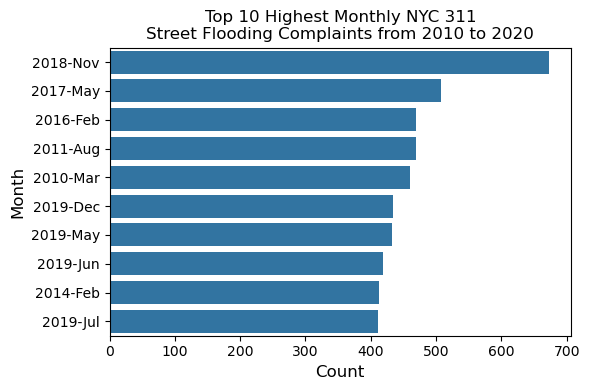

In [26]:
plt.figure(figsize=(6, 4))

sns.barplot(
    data=monthly,
    y='date_formatted',
    x='count',
    color='#1f77b4'
)

label = 'Top 10 Highest Monthly NYC 311\nStreet Flooding Complaints from 2010 to 2020'
plt.title(label, fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Month', fontsize=12)

plt.tight_layout()

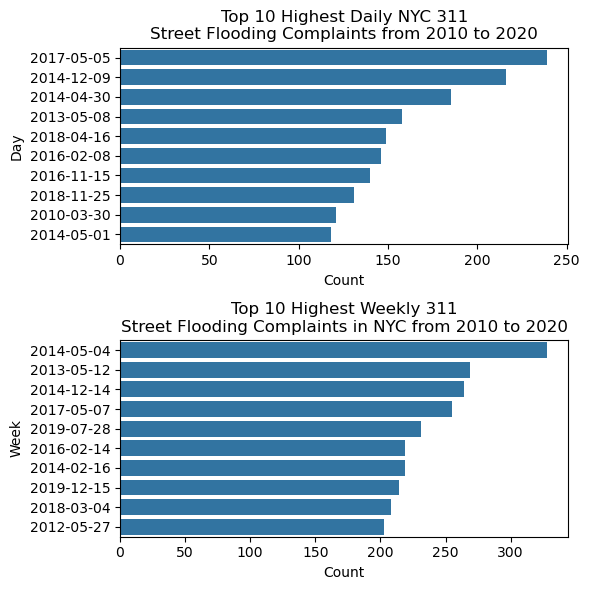

In [27]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(6, 6))

# first plot
sns.barplot(
    data=daily,
    y='date_formatted',
    x='count',
    color='#1f77b4',
    ax=axs[0]
)

label = 'Top 10 Highest Daily NYC 311\nStreet Flooding Complaints from 2010 to 2020'
axs[0].set_title(label)
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Day')

# second plot
sns.barplot(
    data=weekly,
    y='date_formatted',
    x='count',
    color='#1f77b4',
    ax=axs[1]
)

label = 'Top 10 Highest Weekly 311\nStreet Flooding Complaints in NYC from 2010 to 2020'
axs[1].set_title(label)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Week')

fig.tight_layout()

In [28]:
# retrieve count of complaints per day top 10
daily = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('D')
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"unique_key": "count"})
    .assign(date_formatted=lambda x: x.year_month_day.dt.strftime('%Y-%m-%d'))
)

# save days to list and reverse order
days = daily['year_month_day'].values[::-1]

# grab top days in full dataframe to create stacked bar char
top_days_df = df.loc[df['year_month_day'].isin(days)].reset_index(drop=True)

# sanity check
top_days_df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,cross_street_1,cross_street_2,address_type,...,year_month_week,year,month,quarter,week_of_year,day_name,day,hour,time,am_pm
0,34783066,2016-11-15 09:27:00,2016-11-15T10:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,NaN,INTERSECTION,...,2016-11-20,2016,11,4,46,Tuesday,15,9,09:27:00,AM
1,16341356,2010-03-30 11:31:00,2010-03-30T14:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),DEAD END,BEACH CHANNEL DR,ADDRESS,...,2010-04-04,2010,3,1,13,Tuesday,30,11,11:31:00,AM
2,16340534,2010-03-30 09:28:00,2010-03-31T10:14:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),????????????????????????????,79 ST,ADDRESS,...,2010-04-04,2010,3,1,13,Tuesday,30,9,09:28:00,AM
3,16341924,2010-03-30 12:41:00,2010-03-30T16:25:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),163 AVE,164 AVE,ADDRESS,...,2010-04-04,2010,3,1,13,Tuesday,30,12,12:41:00,PM
4,16343010,2010-03-30 12:15:00,2010-04-08T10:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),LORIMER ST,BOERUM ST,INTERSECTION,...,2010-04-04,2010,3,1,13,Tuesday,30,12,12:15:00,PM


In [29]:
# transform to pivot table
pivot_day = pd.pivot_table(
    top_days_df,
    values='unique_key',
    index=['year_month_day'],
    columns=['borough'],
    aggfunc=pd.Series.nunique
)

# order items in legend consistent to other plots
cols = ['Queens', 'Brooklyn', 'Manhattan', 'Staten Island', 'Bronx']

# reordering indexes and columns
pivot_day = pivot_day.loc[days, cols]

# transform datetime index to string
pivot_day.index = pivot_day.reset_index()['year_month_day'].dt.strftime('%Y-%m-%d')

# preview pivot table
pivot_day

borough,Queens,Brooklyn,Manhattan,Staten Island,Bronx
year_month_day,,,,,
2014-05-01,44.0,28.0,NaN,41.0,5.0
2010-03-30,65.0,19.0,2.0,26.0,9.0
2018-11-25,43.0,69.0,1.0,17.0,1.0
2016-11-15,28.0,68.0,11.0,24.0,9.0
2016-02-08,128.0,14.0,NaN,4.0,NaN
2018-04-16,38.0,33.0,19.0,41.0,18.0
2013-05-08,43.0,91.0,14.0,8.0,2.0
2014-04-30,71.0,48.0,12.0,44.0,10.0
2014-12-09,102.0,49.0,16.0,30.0,19.0


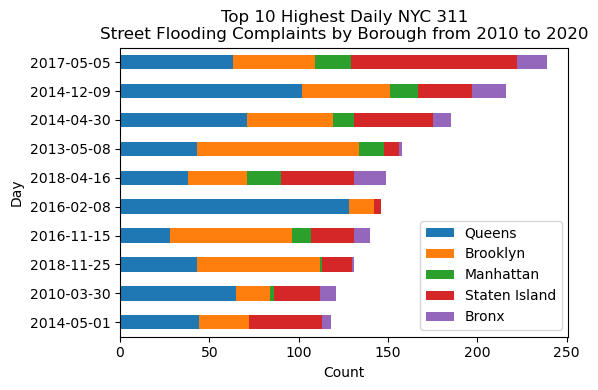

In [30]:
fig, ax = plt.subplots(figsize=(6, 4))

pivot_day.plot.barh(stacked=True, ax=ax)

label = 'Top 10 Highest Daily NYC 311\nStreet Flooding Complaints by Borough from 2010 to 2020'
plt.title(label)

plt.legend(loc=4)
plt.xlabel('Count')
plt.ylabel('Day')
plt.xticks(rotation=0)

plt.tight_layout()

In [31]:
# resample to weekly counts top 10
weekly = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('W')
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"unique_key": "count"})
    .assign(date_formatted=lambda x: x.year_month_day.dt.strftime('%Y-%m-%d'))
)

# save days to list and reverse order
weeks = weekly['year_month_day'].values[::-1]

# grab top days in full dataframe to create stacked bar char
top_weeks_df = df.loc[df['year_month_week'].isin(weeks)].reset_index(drop=True)

# sanity check
top_weeks_df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,cross_street_1,cross_street_2,address_type,...,year_month_week,year,month,quarter,week_of_year,day_name,day,hour,time,am_pm
0,23268930,2012-05-21 16:53:00,2012-05-21T21:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),94 AVE,JAMAICA AVE,ADDRESS,...,2012-05-27,2012,5,2,21,Monday,21,16,16:53:00,PM
1,23267178,2012-05-21 09:17:00,2012-05-23T13:45:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),BAY RIDGE PKWY,76 ST,ADDRESS,...,2012-05-27,2012,5,2,21,Monday,21,9,09:17:00,AM
2,23266212,2012-05-21 15:20:00,2012-05-21T21:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ALBERT CT,BIRCH RD,ADDRESS,...,2012-05-27,2012,5,2,21,Monday,21,15,15:20:00,PM
3,23266208,2012-05-21 17:16:00,2012-05-22T10:20:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),AVENUE R,FILLMORE AVE,ADDRESS,...,2012-05-27,2012,5,2,21,Monday,21,17,17:16:00,PM
4,23268082,2012-05-21 11:20:00,2012-05-23T10:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),E 92 ST,LENOX RD,INTERSECTION,...,2012-05-27,2012,5,2,21,Monday,21,11,11:20:00,AM


In [32]:
# transform to pivot table
pivot_weekly = pd.pivot_table(
    top_weeks_df,
    values='unique_key',
    index=['year_month_week'],
    columns=['borough'],
    aggfunc=pd.Series.nunique
)

# order items in legend consistent to other plots
cols = ['Queens', 'Brooklyn', 'Manhattan', 'Staten Island', 'Bronx']

# reordering indexes and columns
pivot_weekly = pivot_weekly.loc[weeks, cols]

# transform datetime index to string
pivot_weekly.index = pivot_weekly.reset_index()['year_month_week'].dt.strftime('%Y-%m-%d')

# prview pivot table
pivot_weekly

borough,Queens,Brooklyn,Manhattan,Staten Island,Bronx
year_month_week,,,,,
2012-05-27,62,94,14,19,14
2018-03-04,105,49,11,38,5
2019-12-15,93,65,19,27,10
2014-02-16,67,73,22,36,21
2016-02-14,177,25,5,10,2
2019-07-28,82,100,10,27,12
2017-05-07,67,49,25,97,17
2014-12-14,128,58,18,39,21
2013-05-12,114,104,24,22,5


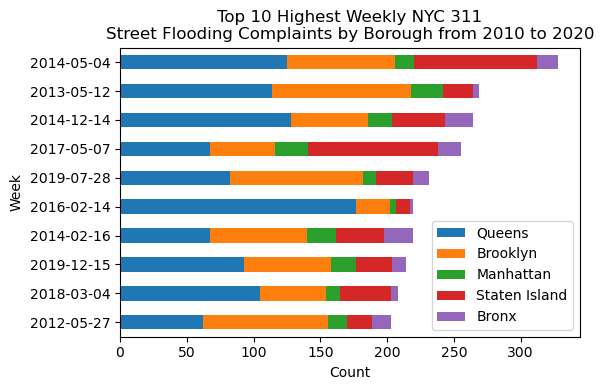

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))

pivot_weekly.plot.barh(stacked=True, ax=ax)

label = 'Top 10 Highest Weekly NYC 311\nStreet Flooding Complaints by Borough from 2010 to 2020'
plt.title(label, fontsize=12)

plt.legend(loc=4, fontsize=10)
plt.xlabel('Count')
plt.ylabel('Week')
plt.xticks(rotation=0)

plt.tight_layout()

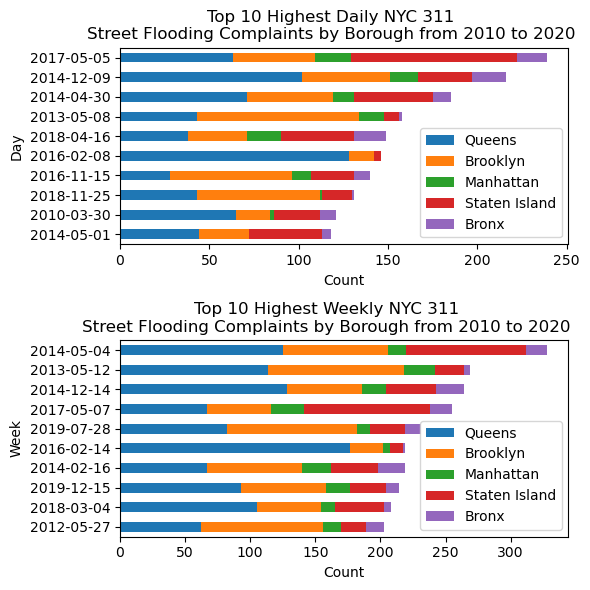

In [34]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(6, 6))

# first plot
pivot_day.plot.barh(stacked=True, ax=axs[0])

label = 'Top 10 Highest Daily NYC 311\nStreet Flooding Complaints by Borough from 2010 to 2020'
axs[0].set_title(label, fontsize=12, x=.47)

axs[0].legend(loc=4, fontsize=10)
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Day')

# second plot
pivot_weekly.plot.barh(stacked=True, ax=axs[1])

label = 'Top 10 Highest Weekly NYC 311\nStreet Flooding Complaints by Borough from 2010 to 2020'
axs[1].set_title(label, fontsize=12, x=.46)

axs[1].legend(loc=4, fontsize=10)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Week')

fig.tight_layout()
plt.savefig('figures/daily-and-weekly-boro-counts.png', dpi=250, bbox_inches='tight')

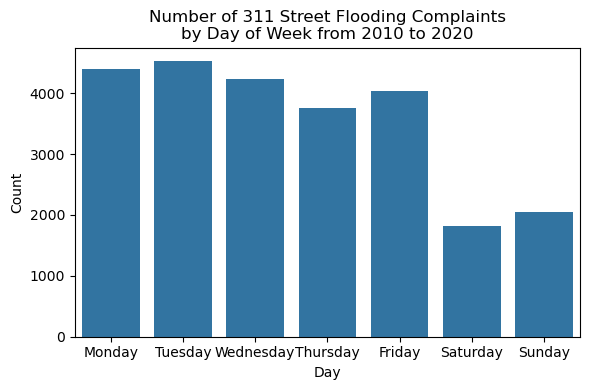

In [35]:
plt.figure(figsize=(6, 4))

order = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
    'Saturday', 'Sunday'
]

sns.countplot(
    x=df['day_name'],
    color='#1f77b4',
    order=order
)

label = 'Number of 311 Street Flooding Complaints\nby Day of Week from 2010 to 2020'
plt.title(label)
plt.xlabel('Day')
plt.ylabel('Count')

plt.tight_layout()

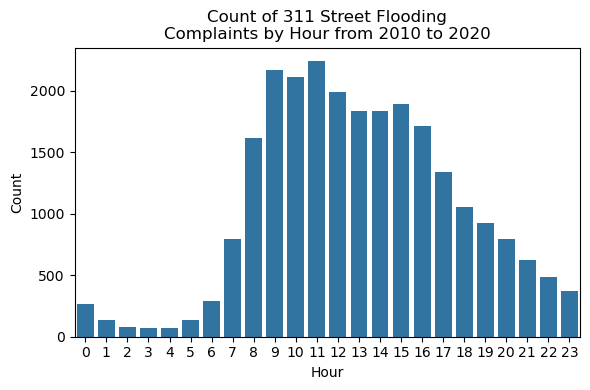

In [36]:
plt.figure(figsize=(6, 4))

sns.countplot(x=df['hour'], color='#1f77b4')

label = 'Count of 311 Street Flooding\nComplaints by Hour from 2010 to 2020'
plt.title(label)
plt.xlabel('Hour')
plt.ylabel('Count')

plt.tight_layout()

In [37]:
# transform to minutes
time = (
    df
    .groupby(by='time')['unique_key']
    .count()
    .rename(index="count")
    .reset_index()
)

time.time = pd.to_datetime(time.time, format='%H:%M:%S')

time.head()

,time,count
0,1900-01-01 00:00:00,71
1,1900-01-01 00:01:00,3
2,1900-01-01 00:02:00,5
3,1900-01-01 00:03:00,4
4,1900-01-01 00:04:00,5


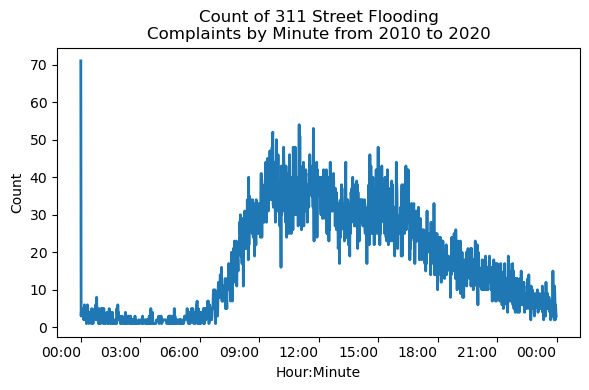

In [38]:
fig, ax = plt.subplots(figsize=(6, 4))

time.plot(
    x='time',
    y='count',
    ax=ax, 
    rot=0,
    color='#1f77b4', 
    linewidth=2,
    legend=False
)

myformat = matplotlib.dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myformat)

label = 'Count of 311 Street Flooding\nComplaints by Minute from 2010 to 2020'
plt.title(label)
plt.xlabel('Hour:Minute')
plt.ylabel('Count')

plt.tight_layout()

In [39]:
# transform to 15min rolling mean
time = (
    time
    .set_index('time')['count']
    .rolling(15)
    .mean()
)

time

time
1900-01-01 00:00:00         NaN
1900-01-01 00:01:00         NaN
1900-01-01 00:02:00         NaN
1900-01-01 00:03:00         NaN
1900-01-01 00:04:00         NaN
                         ...   
1900-01-01 23:55:00    5.800000
1900-01-01 23:56:00    5.533333
1900-01-01 23:57:00    5.800000
1900-01-01 23:58:00    5.866667
1900-01-01 23:59:00    5.800000
Name: count, Length: 1361, dtype: float64

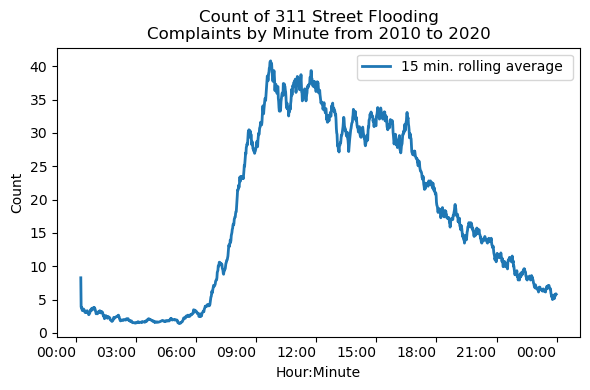

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))

myformat = matplotlib.dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myformat)

time.plot(
    y='count',
    ax=ax, 
    rot=0,
    color='#1f77b4', 
    linewidth=2,
    label='15 min. rolling average ', 
    legend=True
)

label = 'Count of 311 Street Flooding\nComplaints by Minute from 2010 to 2020'
plt.title(label)
plt.legend()
plt.xlabel('Hour:Minute')
plt.ylabel('Count')

plt.tight_layout()

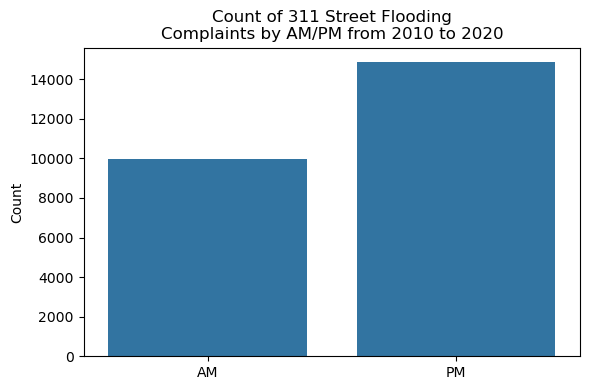

In [41]:
plt.figure(figsize=(6, 4))

order = ['AM', 'PM']

sns.countplot(
    x=df['am_pm'],
    color='#1f77b4',
    order=order
)

label = 'Count of 311 Street Flooding\nComplaints by AM/PM from 2010 to 2020'
plt.title(label)
plt.xlabel('')
plt.ylabel('Count')

plt.tight_layout()

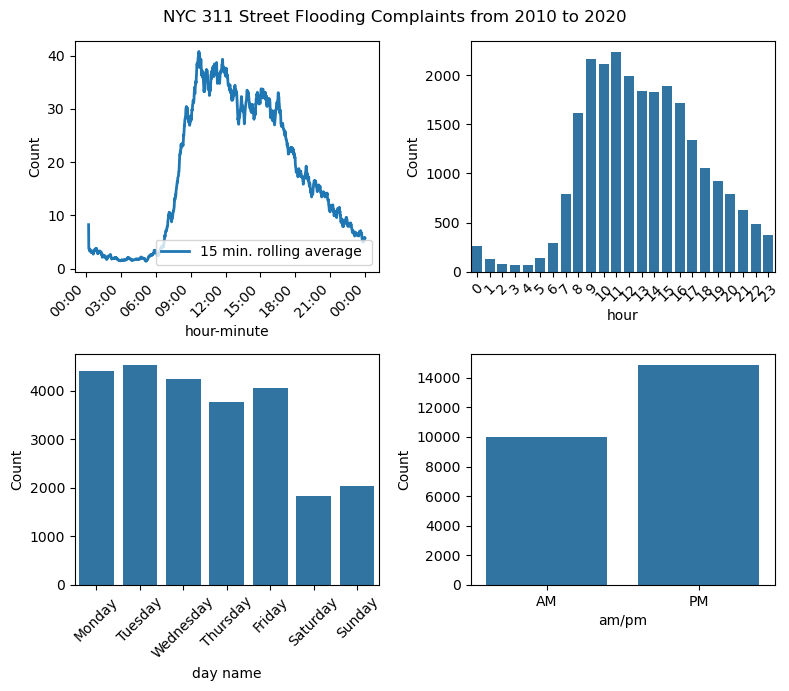

In [42]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(8, 7))

time.plot(
    x='time',
    y='count',
    ax=axs[0,0], 
    rot=0,
    color='#1f77b4', 
    linewidth=2,
    legend=True,
    label='15 min. rolling average '
)

myFmt = matplotlib.dates.DateFormatter('%H:%M')
axs[0,0].xaxis.set_major_formatter(myFmt)
axs[0,0].set_ylabel('count') 
axs[0,0].set_xlabel('hour-minute')

sns.countplot(
    x=df['hour'],
    color='#1f77b4',
    ax=axs[0,1]
)

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(
    x=df['day_name'],
    color='#1f77b4',
    order=order,
    ax=axs[1, 0]
)
axs[1, 0].set_xlabel('day name')
axs[1, 0].tick_params(axis='x', rotation=45)
axs[0, 1].tick_params(axis='x', rotation=45)
axs[0, 0].tick_params(axis='x', rotation=45)

order = ['AM', 'PM']
sns.countplot(
    x=df['am_pm'],
    color='#1f77b4',
    order=order,
    ax=axs[1,1])
axs[1,1].set_xlabel('am/pm')

for ax in axs.flatten():
    ax.set_ylabel('Count')

fig.suptitle('NYC 311 Street Flooding Complaints from 2010 to 2020', fontsize=12) 

fig.tight_layout()

# Resampling

In [43]:
daily_df = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('D')
    .sum()
    .rename(index="count")
)

daily_df.head()

year_month_day
2010-01-02    3
2010-01-03    0
2010-01-04    1
2010-01-05    1
2010-01-06    4
Freq: D, Name: count, dtype: int64

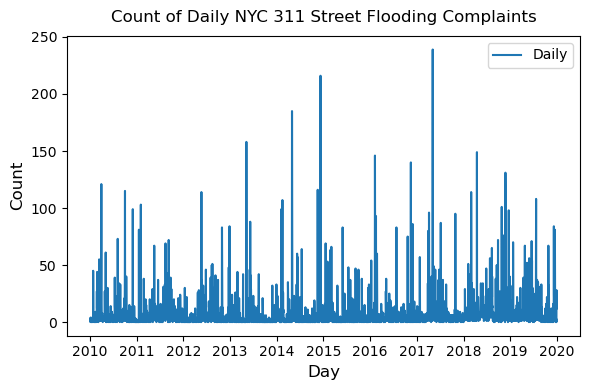

In [44]:
plt.figure(figsize=(6, 4))

sns.lineplot(data=daily_df, label='Daily')

label = 'Count of Daily NYC 311 Street Flooding Complaints'
plt.title(label, fontsize=12, pad=10)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()

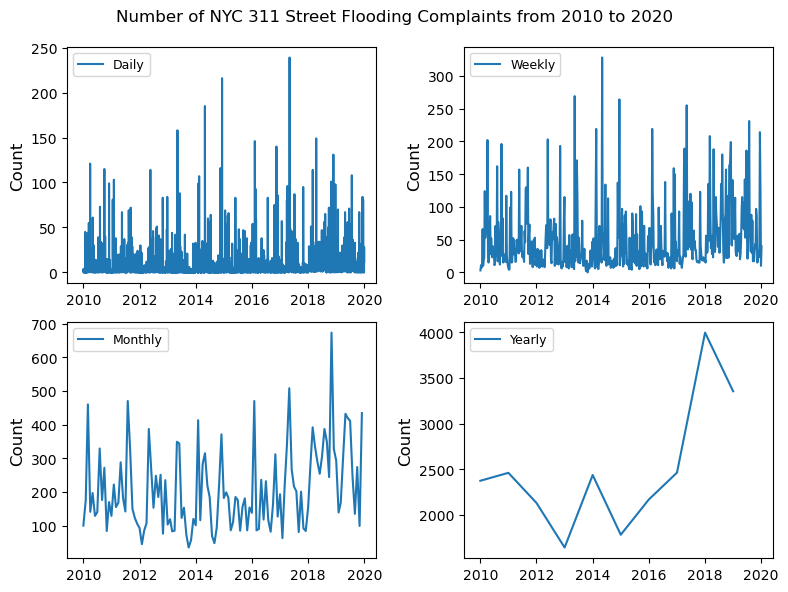

In [45]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(8, 6))

years = mdates.YearLocator() 

sns.lineplot(
    data=daily_df.resample('D').sum(), 
    label='Daily', 
    ax=axs[0,0]
)
sns.lineplot(
    data=daily_df.resample('W').sum(), 
    label='Weekly', 
    ax=axs[0,1]
)

sns.lineplot(
    data=daily_df.resample('MS').sum(), 
    label='Monthly', 
    ax=axs[1,0]
)

sns.lineplot(
    data=daily_df.resample('YS').sum(), 
    label='Yearly', 
    ax=axs[1,1]
) 

plt.suptitle('Number of NYC 311 Street Flooding Complaints from 2010 to 2020', fontsize=12)

years = mdates.YearLocator(2)
for ax in axs.flatten():
    ax.legend(loc=2, fontsize=9)
    ax.set_xlabel('', fontsize=12)
    ax.xaxis.set_major_locator(years)  
    ax.set_xlim([datetime.date(2009, 6, 1), datetime.date(2020, 6, 1)]) 
    ax.set_ylabel('Count', fontsize=12) 

fig.tight_layout()

## Seasonality

In [46]:
seasonality_month = (
    df
    .groupby(by=['year_month_day'])['unique_key']
    .count()
    .rename(index="count")
    .reset_index()
    .set_index('year_month_day')
    .resample('MS')
    .sum()
    .reset_index()
    .assign(month=lambda x: x.year_month_day.dt.month)
)

seasonality_month.head()

,year_month_day,count,month
0,2010-01-01,100,1
1,2010-02-01,176,2
2,2010-03-01,460,3
3,2010-04-01,141,4
4,2010-05-01,197,5


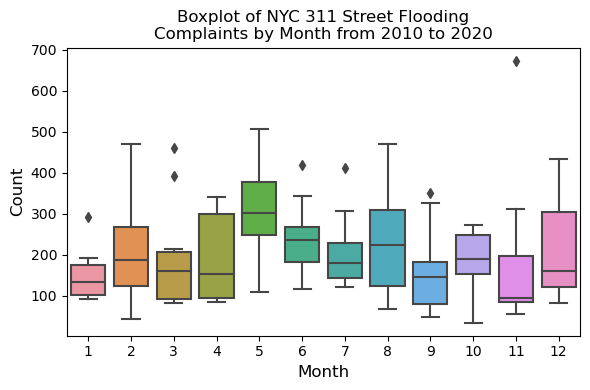

In [47]:
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=seasonality_month,
    x='month',
    y='count'
)

label = 'Boxplot of NYC 311 Street Flooding\nComplaints by Month from 2010 to 2020'
plt.title(label, fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()

In [48]:
seasonality_quarter = (
    df
    .groupby(by=['year_month_day'])['unique_key']
    .count()
    .rename(index="count")
    .resample('QS').sum()
    .reset_index()
    .assign(quarter=lambda x: x.year_month_day.dt.quarter)
)

seasonality_quarter.head()

,year_month_day,count,quarter
0,2010-01-01,736,1
1,2010-04-01,467,2
2,2010-07-01,645,3
3,2010-10-01,526,4
4,2011-01-01,506,1


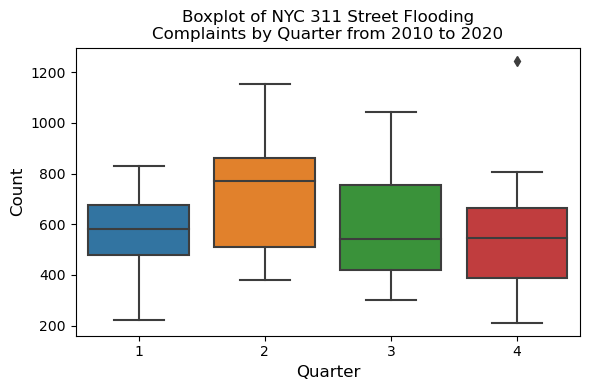

In [49]:
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=seasonality_quarter,
    x='quarter',
    y='count'
)

label = 'Boxplot of NYC 311 Street Flooding\nComplaints by Quarter from 2010 to 2020'
plt.title(label, fontsize=12)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()

In [50]:
seasonality_week = (
    df
    .groupby(by=['year_month_day'])['unique_key']
    .count()
    .rename(index="count")
    .reset_index()
    .set_index('year_month_day')
    .resample('W')
    .sum()
    .reset_index()
    .assign(week_of_year=lambda x: x.year_month_day.dt.isocalendar().week)
)

seasonality_week.head()

,year_month_day,count,week_of_year
0,2010-01-03,3,53
1,2010-01-10,11,1
2,2010-01-17,7,2
3,2010-01-24,13,3
4,2010-01-31,66,4


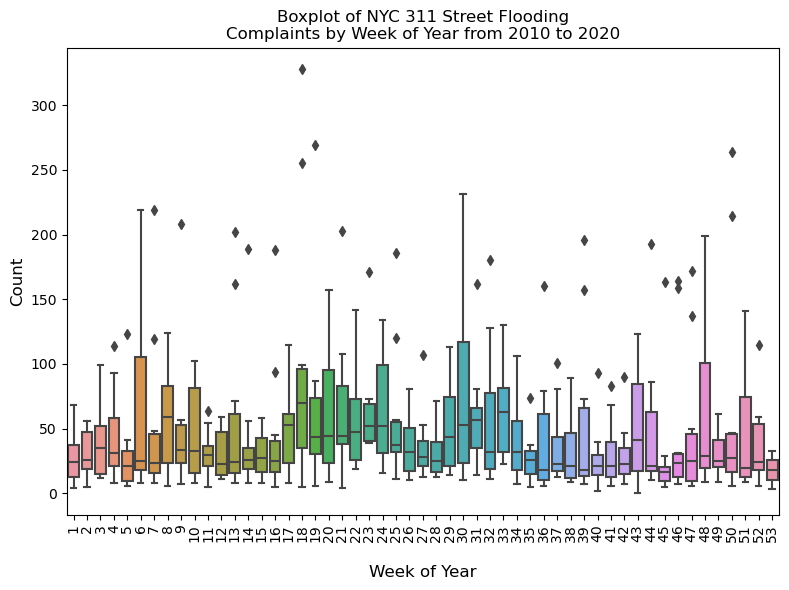

In [51]:
plt.figure(figsize=(8, 6))

sns.boxplot(
    data=seasonality_week,
    x='week_of_year',
    y='count'
)

label = 'Boxplot of NYC 311 Street Flooding\nComplaints by Week of Year from 2010 to 2020'
plt.title(label, fontsize=12)
plt.xlabel('\nWeek of Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)

plt.tight_layout()

## Resampling for Frequency Average

In [52]:
daily = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('D')
    .sum()
    .rename(index="count")
)

daily.head(10)

year_month_day
2010-01-02    3
2010-01-03    0
2010-01-04    1
2010-01-05    1
2010-01-06    4
2010-01-07    3
2010-01-08    1
2010-01-09    1
2010-01-10    0
2010-01-11    0
Freq: D, Name: count, dtype: int64

In [53]:
weekly_mean = daily.resample('W').mean()

weekly_mean.head()

year_month_day
2010-01-03    1.500000
2010-01-10    1.571429
2010-01-17    1.000000
2010-01-24    1.857143
2010-01-31    9.428571
Freq: W-SUN, Name: count, dtype: float64

In [54]:
monthly_mean = daily.resample('MS').mean()

monthly_mean.head()

year_month_day
2010-01-01     3.333333
2010-02-01     6.285714
2010-03-01    14.838710
2010-04-01     4.700000
2010-05-01     6.354839
Freq: MS, Name: count, dtype: float64

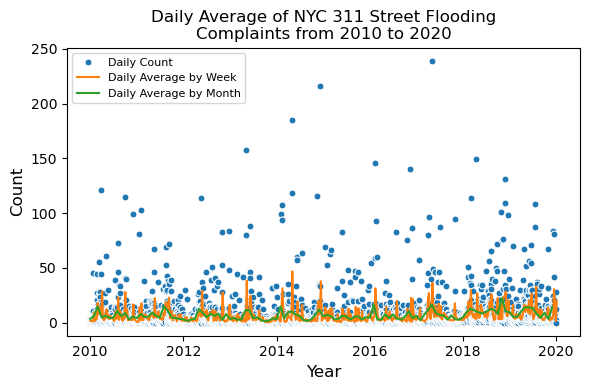

In [55]:
plt.figure(figsize=(6, 4))

sns.lineplot(
    data=daily,
    marker='.',
    markersize=10,
    linewidth=0,
    label='Daily Count'
)

sns.lineplot(
    data=weekly_mean,
    label='Daily Average by Week'
)

sns.lineplot(
    data=monthly_mean,
    label='Daily Average by Month'
)

label = 'Daily Average of NYC 311 Street Flooding\nComplaints from 2010 to 2020'
plt.title(label, fontsize=12)
plt.legend(fontsize=8)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()

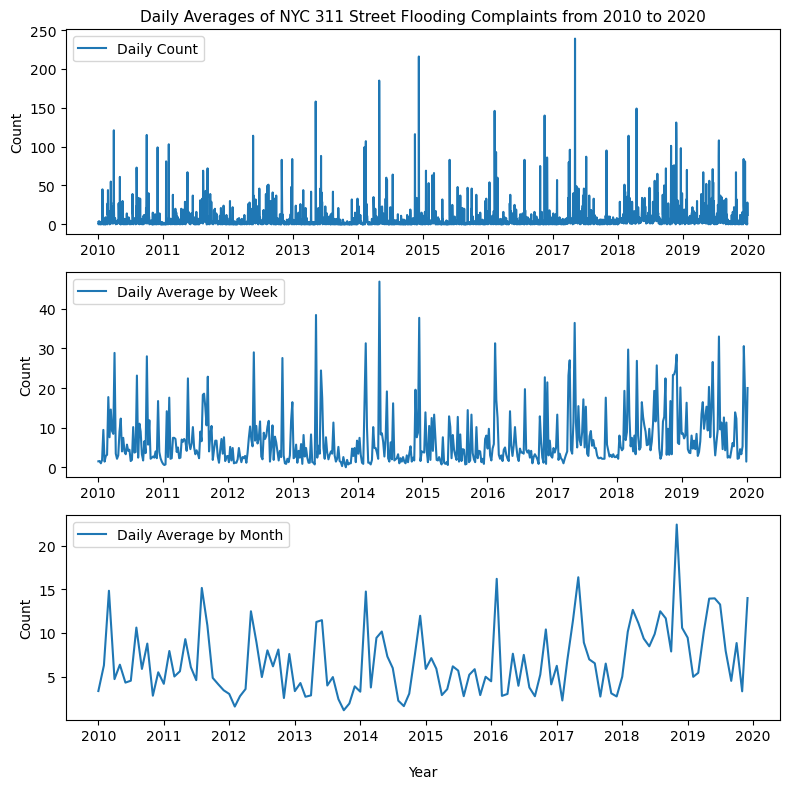

In [56]:
fig, axs = plt.subplots(3, 1, sharey=False, figsize=(8, 8))

years = mdates.YearLocator()

sns.lineplot(
    data=daily, 
    label='Daily Count', 
    ax=axs[0]
)
sns.lineplot(
    data=weekly_mean, 
    label='Daily Average by Week', 
    ax=axs[1]
)
sns.lineplot(
    data=monthly_mean, 
    label='Daily Average by Month', 
    ax=axs[2])

label = 'Daily Averages of NYC 311 Street Flooding Complaints from 2010 to 2020'
axs[0].set_title(label, fontsize=11)

for ax in axs.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.legend(loc=2, fontsize=10)
    ax.xaxis.set_major_locator(years)
    
plt.xlabel('\nYear')    
    
plt.tight_layout()

## Rolling Averages

In [57]:
daily = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('D')
    .sum()
    .rename(index="count")
)

daily.head(10)

year_month_day
2010-01-02    3
2010-01-03    0
2010-01-04    1
2010-01-05    1
2010-01-06    4
2010-01-07    3
2010-01-08    1
2010-01-09    1
2010-01-10    0
2010-01-11    0
Freq: D, Name: count, dtype: int64

In [58]:
(daily
 .rolling(7)
 .mean()
 .head(10)
)

year_month_day
2010-01-02         NaN
2010-01-03         NaN
2010-01-04         NaN
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08    1.857143
2010-01-09    1.571429
2010-01-10    1.571429
2010-01-11    1.428571
Freq: D, Name: count, dtype: float64

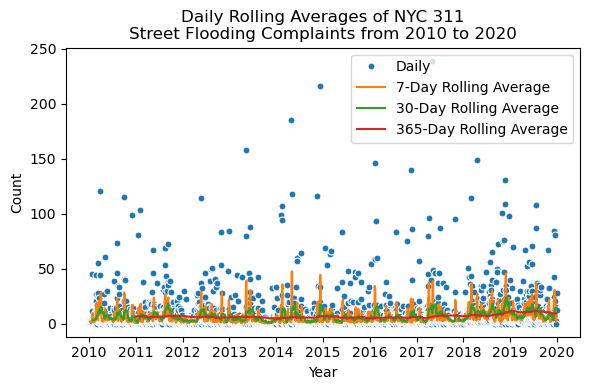

In [59]:
plt.figure(figsize=(6, 4))

sns.lineplot(
    data=daily,
    marker='.',
    markersize=10,
    linewidth=0,
    label='Daily'
)

sns.lineplot(
    data=daily.rolling(7).mean(),
    label='7-Day Rolling Average'
)

sns.lineplot(
    data=daily.rolling(30).mean(),
    label='30-Day Rolling Average'
)

sns.lineplot(
    data=daily.rolling(365).mean(),
    label='365-Day Rolling Average'
)

label = 'Daily Rolling Averages of NYC 311\nStreet Flooding Complaints from 2010 to 2020'
plt.title(label)
plt.xlabel('Year')
plt.ylabel('Count')

plt.tight_layout()

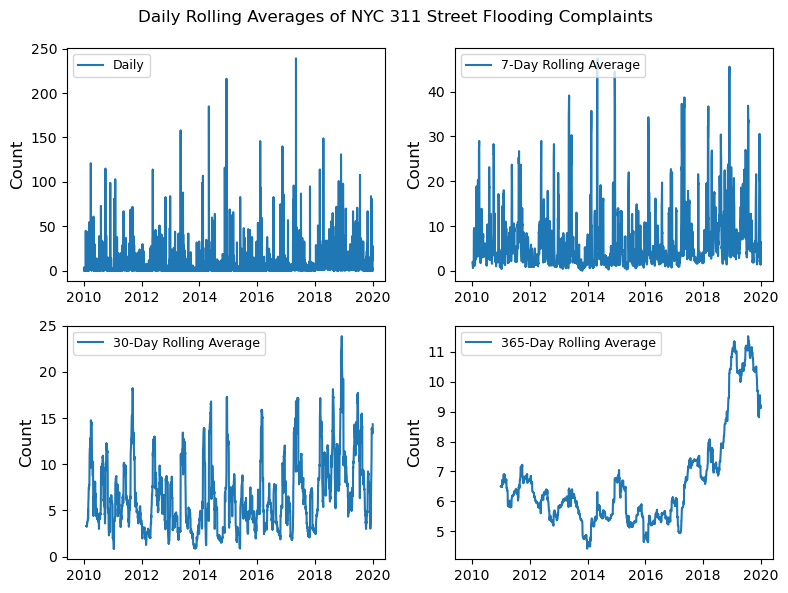

In [60]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(8, 6))

sns.lineplot(
    data=daily, 
    label='Daily', 
    ax=axs[0,0]
)
sns.lineplot(
    data=daily.rolling(7).mean(), 
    label='7-Day Rolling Average', 
    ax=axs[0,1]
)
sns.lineplot(
    data=daily.rolling(30).mean(), 
    label='30-Day Rolling Average', 
    ax=axs[1,0]
)
sns.lineplot(
    data=daily.rolling(365).mean(), 
    label='365-Day Rolling Average', 
    ax=axs[1,1]
)

plt.suptitle(
    'Daily Rolling Averages of NYC 311 Street Flooding Complaints', 
    fontsize=12, 
)

years = mdates.YearLocator(2)
for ax in axs.flatten():
    ax.legend(loc=2, fontsize=9)
    ax.set_xlabel('', fontsize=12)
    ax.xaxis.set_major_locator(years)  
    ax.set_xlim([datetime.date(2009, 6, 1), datetime.date(2020, 6, 1)]) 
    ax.set_ylabel('Count', fontsize=12)    
    
fig.tight_layout()

# Manually Formatting Date Tick Labels

Not necessarily applicable to this project, but I wanted to practice my matplotlib date labels.

In [61]:
daily = (
    df
    .groupby(by='year_month_day')['unique_key']
    .count()
    .resample('D')
    .sum()
    .rename(index="count")
)

daily.head(10)

year_month_day
2010-01-02    3
2010-01-03    0
2010-01-04    1
2010-01-05    1
2010-01-06    4
2010-01-07    3
2010-01-08    1
2010-01-09    1
2010-01-10    0
2010-01-11    0
Freq: D, Name: count, dtype: int64

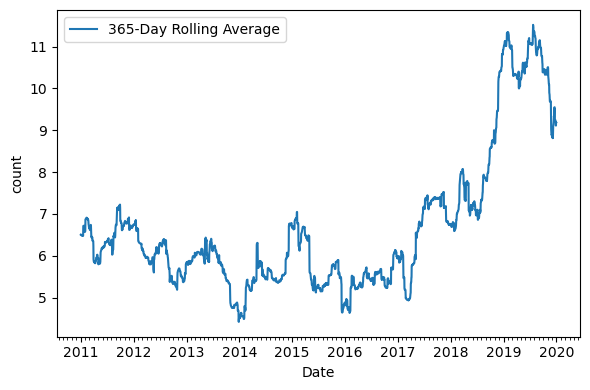

In [62]:
fig, ax = plt.subplots(figsize=(6, 4))

years = mdates.YearLocator()   
months = mdates.MonthLocator()  
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

sns.lineplot(
    data=daily.rolling(365).mean(), 
    label='365-Day Rolling Average', 
    ax=ax
)

plt.legend(loc=2)
plt.xlabel('Date')
plt.tight_layout()

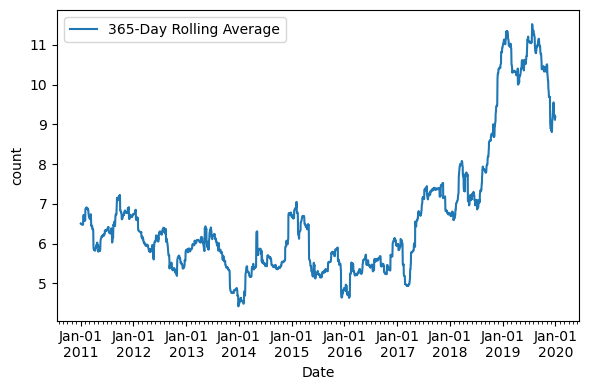

In [63]:
fig, ax = plt.subplots(figsize=(6, 4))

years = mdates.YearLocator() 
months = mdates.MonthLocator() 
years_fmt = mdates.DateFormatter('%b-%d\n%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

sns.lineplot(
    data=daily.rolling(365).mean(), 
    label='365-Day Rolling Average', 
    ax=ax
)

plt.legend(loc=2)
plt.xlabel('Date')
plt.tight_layout()

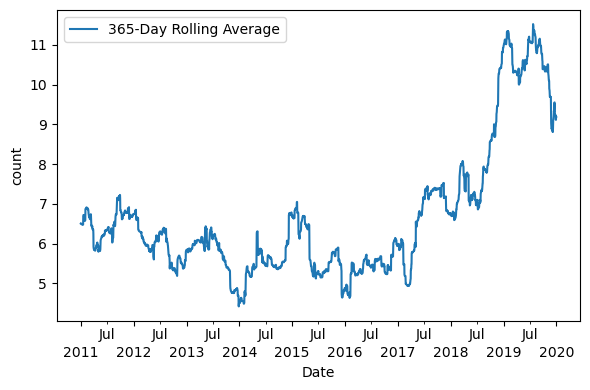

In [64]:
fig, ax = plt.subplots(figsize=(6, 4))

years = mdates.YearLocator()
months = mdates.MonthLocator(7)
monthsFmt = mdates.DateFormatter('%b') 
yearsFmt = mdates.DateFormatter('\n%Y')

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

sns.lineplot(
    data=daily.rolling(365).mean(), 
    label='365-Day Rolling Average', 
    ax=ax
)

plt.legend(loc=2)
plt.xlabel('Date')
plt.tight_layout()

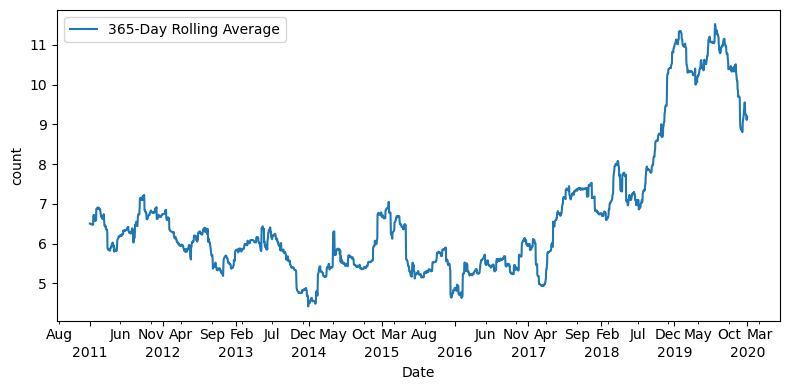

In [65]:
fig, ax = plt.subplots(figsize=(8, 4))

years = mdates.YearLocator()
months = mdates.MonthLocator(interval=5)
monthsFmt = mdates.DateFormatter('%b') 
yearsFmt = mdates.DateFormatter('\n%Y')

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

sns.lineplot(
    data=daily.rolling(365).mean(), 
    label='365-Day Rolling Average', 
    ax=ax
)

plt.legend(loc=2)
plt.xlabel('Date')
plt.tight_layout()